In [1]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [2]:
extra_features_df=functions.getGame_df()
df=functions.load_dataset(session)

grand_df=pd.merge(left=df,
                  right=extra_features_df,
                  left_on='ID',
                  right_on='id')
grand_df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)
#df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)


## Dummy Classifier
If I didn't know anything, I would pick the team with the higher win percentage every time. 

In [3]:
def trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['homeTeam_id'])|(grand_df['awayTeam_id']==row['homeTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

def away_trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['awayTeam_id'])|(grand_df['awayTeam_id']==row['awayTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

df['homeWin_pct']=grand_df.apply(lambda x: trailing_winPct(x),axis=1)

df['awayWin_pct']=grand_df.apply(lambda x: away_trailing_winPct(x),axis=1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


In [150]:
from sklearn.base import BaseEstimator

class WinPercentageClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        preds=X.apply(lambda row: 1 if row['homeWin_pct']>row['awayWin_pct'] else 0,axis=1)
        return preds

In [152]:
import sklearn
from sklearn.model_selection import train_test_split

X=df.drop(columns=['ID','home_score','away_score',])
y=df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=12)

In [153]:
dummy = WinPercentageClassifier()

In [154]:
dummy.fit(X_train)
dummy_preds = dummy.predict(X_test)

In [15]:
print(f1_score(y_test,dummy_preds))
dummy_preds.value_counts()

0.5731584258324924


1    489
0    483
dtype: int64

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve


print('dummy f1: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='f1')))
print('dummy accuracy: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='accuracy')))
print('dummy precision: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='precision')))
print('dummy recall: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='recall')))

dummy f1:  0.5893040912369256
dummy accuracy:  0.5793405890156091
dummy precision:  0.6082246841898
dummy recall:  0.5717163999240397


## Create a model to beat the dummy

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold

### Cross Validate Function // Plot confusion matrix function

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

In [26]:
def plot_confusion_matrix(true,predicted):
    import itertools
    cm=confusion_matrix(true,predicted)
    classes=['Home Team Loss','Home Team Win']
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    #plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    plt.grid(b=None)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="black" if cm[i, j] > thresh else "black")
    plt.show()

In [27]:
def pipeline_cv(splits, X, Y, pipeline, average_method=None):
    
    kfold = KFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc_scores = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y[train])
        prediction = fit.predict(X.iloc[test])
        
        scores = fit.score(X.iloc[test],Y[test])
        
        display(pd.DataFrame(metrics.classification_report(Y[test],prediction,output_dict=True)))
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction)*100)
        
        #print('precision:',precision_score(Y[test], prediction))
        recall.append(recall_score(Y[test], prediction)*100)
        #print('recall:   ',recall_score(Y[test], prediction))
        f1.append(f1_score(Y[test], prediction)*100)
        #print('f1 score: ',f1_score(Y[test], prediction))
        #print('-'*50)
        
        roc_auc_scores.append(roc_auc_score(Y[test],prediction)*100)
        
        plot_confusion_matrix(Y[test],prediction)
        
        

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    print("roc_auc score: %.2f%% (+/- %.2f%%)" % (np.mean(roc_auc_scores), np.std(roc_auc_scores)))

In [38]:
from sklearn.base import TransformerMixin

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_hitters_slashInteraction = True):
        self.add_hitters_slashInteraction=add_hitters_slashInteraction
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.add_hitters_slashInteraction:
            #X.loc[:,'homeHitter_slashInteraction']=X.apply(lambda row:row['home_hitters_OBP_mean']*row['home_hitters_SLG_mean'],axis=1)
            X.loc[:,'homeHitter_slashInteraction'] = (X.loc[:,'home_hitters_OBP_mean']
                                           *X.loc[:,'home_hitters_SLG_mean']
                                           *X.loc[:,'home_hitters_BA_mean'])
            X.loc[:,'awayHitter_slashInteraction'] = (X.loc[:,'away_hitters_OBP_mean']
                                           *X.loc[:,'away_hitters_SLG_mean']
                                           *X.loc[:,'away_hitters_BA_mean'])
                
            
            return X        
        else:
            pass

In [29]:
#interaction variables
from sklearn.preprocessing import PolynomialFeatures

### Logistic Regression

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.607656,0.606498,0.606996,0.607077,0.607060
recall,0.538136,0.672000,0.606996,0.605068,0.606996
f1-score,0.570787,0.637571,0.606996,0.604179,0.605141
support,472.000000,500.000000,0.606996,972.000000,972.000000


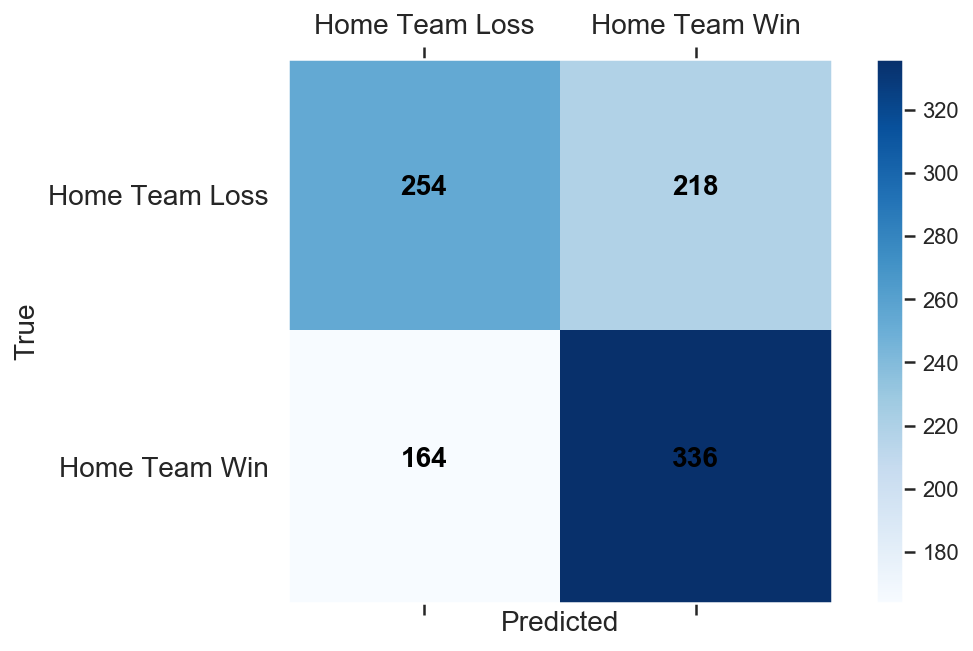

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.531250,0.579932,0.5607,0.555591,0.557344
recall,0.452328,0.654511,0.5607,0.553419,0.560700
f1-score,0.488623,0.614968,0.5607,0.551796,0.556345
support,451.000000,521.000000,0.5607,972.000000,972.000000


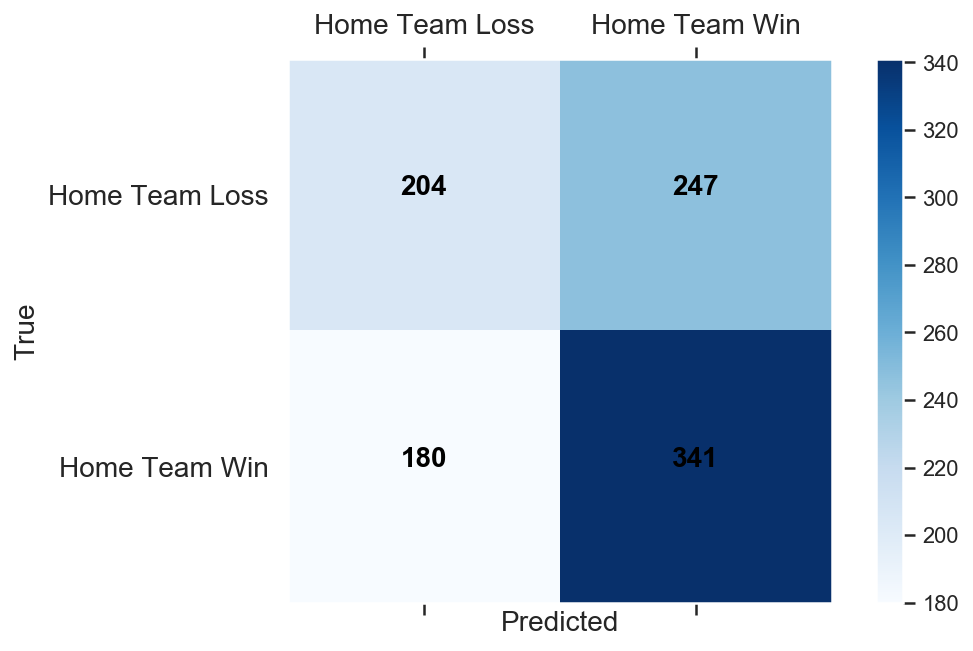

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.534527,0.574871,0.558642,0.554699,0.555944
recall,0.458333,0.647287,0.558642,0.552810,0.558642
f1-score,0.493506,0.608933,0.558642,0.551220,0.554783
support,456.000000,516.000000,0.558642,972.000000,972.000000


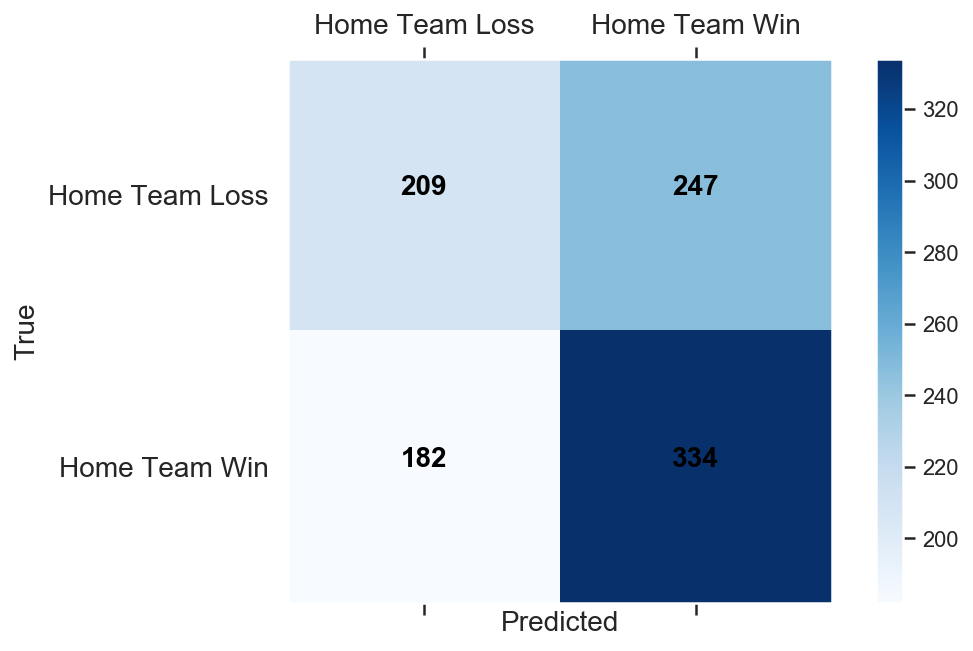

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.569014,0.583468,0.578189,0.576241,0.576643
recall,0.440087,0.701754,0.578189,0.570921,0.578189
f1-score,0.496314,0.637168,0.578189,0.566741,0.570654
support,459.000000,513.000000,0.578189,972.000000,972.000000


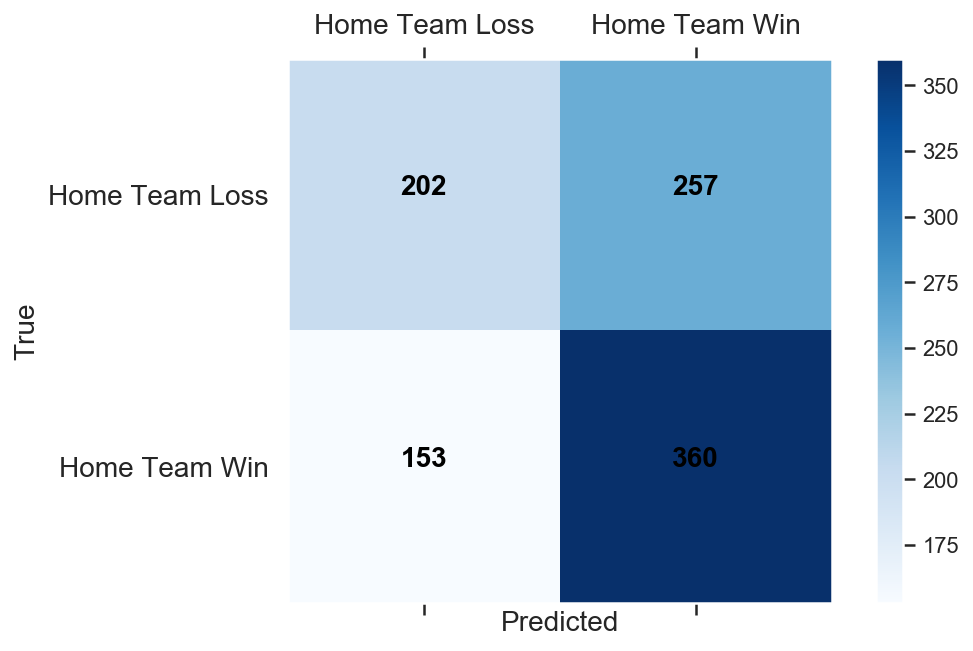

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.544737,0.583756,0.568486,0.564247,0.565553
recall,0.456954,0.666023,0.568486,0.561488,0.568486
f1-score,0.496999,0.622182,0.568486,0.559590,0.563780
support,453.000000,518.000000,0.568486,971.000000,971.000000


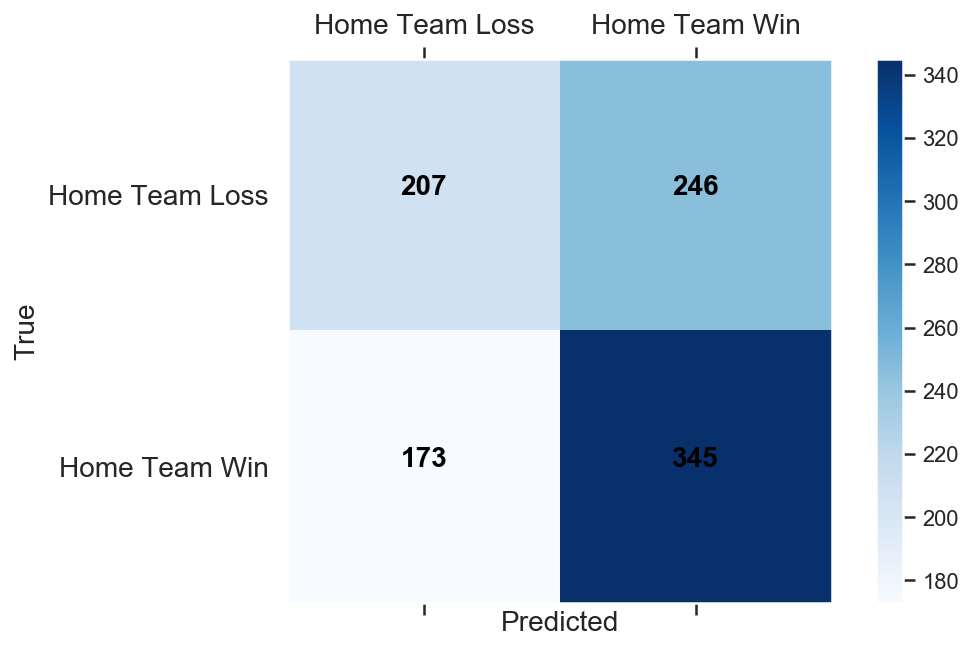

accuracy: 57.46% (+/- 1.76%)
precision: 58.57% (+/- 1.09%)
recall: 66.83% (+/- 1.88%)
f1 score: 62.42% (+/- 1.16%)
roc_auc score: 56.87% (+/- 1.93%)


In [135]:
lr_clf = LogisticRegression(max_iter=1000)

lr_pipe=Pipeline([
    ('attr_adder',CombinedAttributesAdder()),
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',lr_clf))
])

pipeline_cv(5,X,y,lr_pipe)

##### random search Logistic Regression 

In [136]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import numpy as np

# scoring metrics
f1_scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
precision_scorer = metrics.make_scorer(metrics.precision_score)
recall_scorer = metrics.make_scorer(metrics.recall_score)
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score)

In [137]:
lr_random_search_params = {
    'attr_adder__add_hitters_slashInteraction':[True,False],
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__solver':['liblinear'],
    'classifier__penalty':['l1','l2'],
    'classifier__intercept_scaling':np.linspace(.5,.6,num=15),
    'classifier__max_iter':[1000],
    'classifier__C':np.linspace(1.6,1.7,num=15)
}

In [138]:
lr_random_search = RandomizedSearchCV(lr_pipe,
                                      lr_random_search_params,
                                      cv=5,n_jobs=-1,
                                      scoring=auc_scorer,verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.559690,0.577436,0.57037,0.568563,0.568968
recall,0.467012,0.664699,0.57037,0.565855,0.570370
f1-score,0.509168,0.618002,0.57037,0.563585,0.566071
support,773.000000,847.000000,0.57037,1620.000000,1620.000000


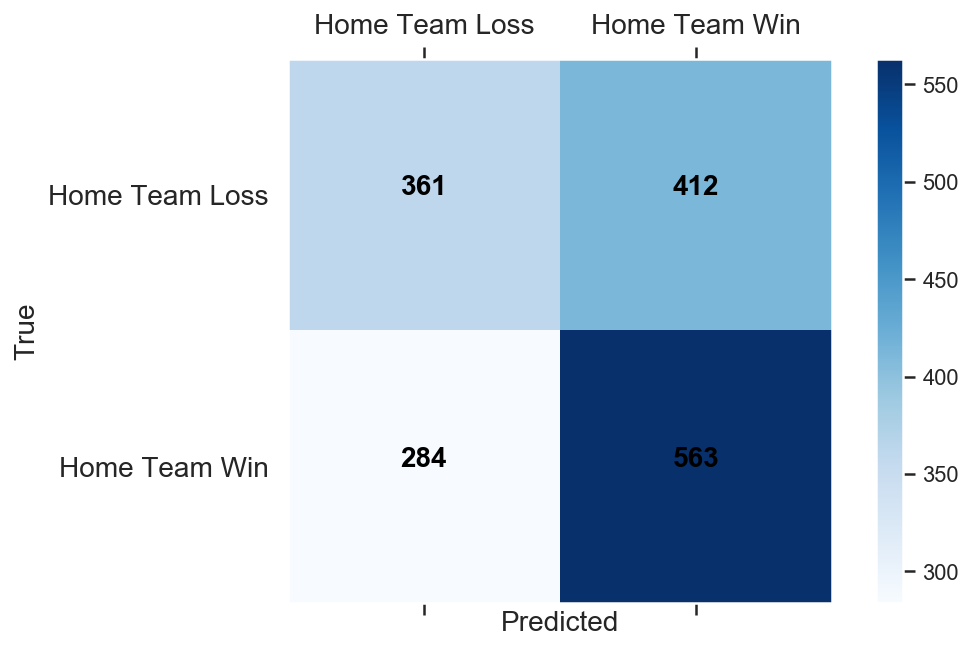

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.5s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.535188,0.570862,0.557407,0.553025,0.554126
recall,0.430263,0.669767,0.557407,0.550015,0.557407
f1-score,0.477024,0.616372,0.557407,0.546698,0.550999
support,760.000000,860.000000,0.557407,1620.000000,1620.000000


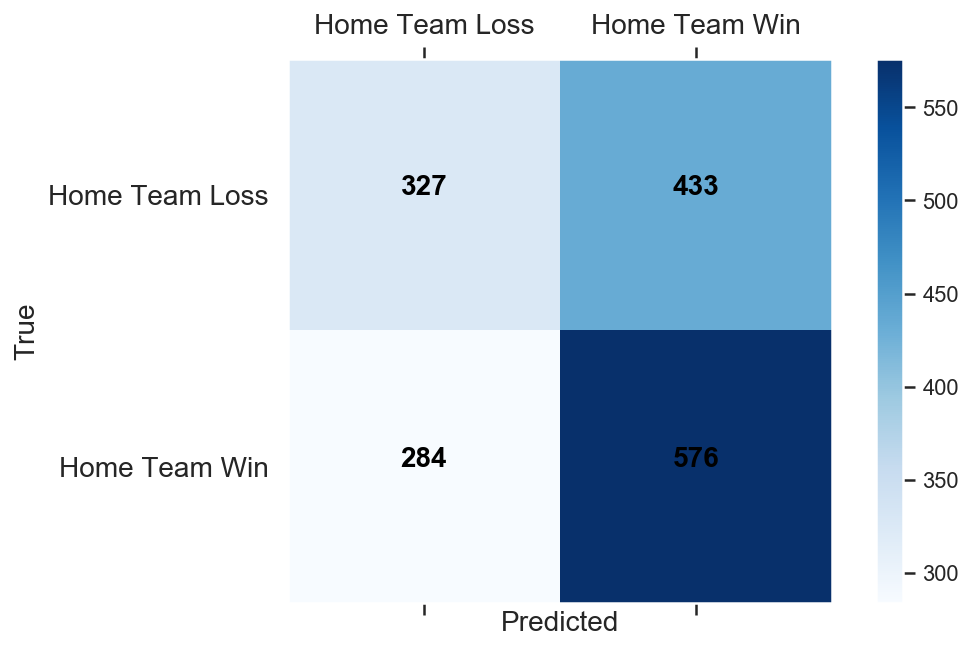

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.7s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.571200,0.596579,0.586782,0.583890,0.584697
recall,0.470976,0.688734,0.586782,0.579855,0.586782
f1-score,0.516269,0.639353,0.586782,0.577811,0.581726
support,758.000000,861.000000,0.586782,1619.000000,1619.000000


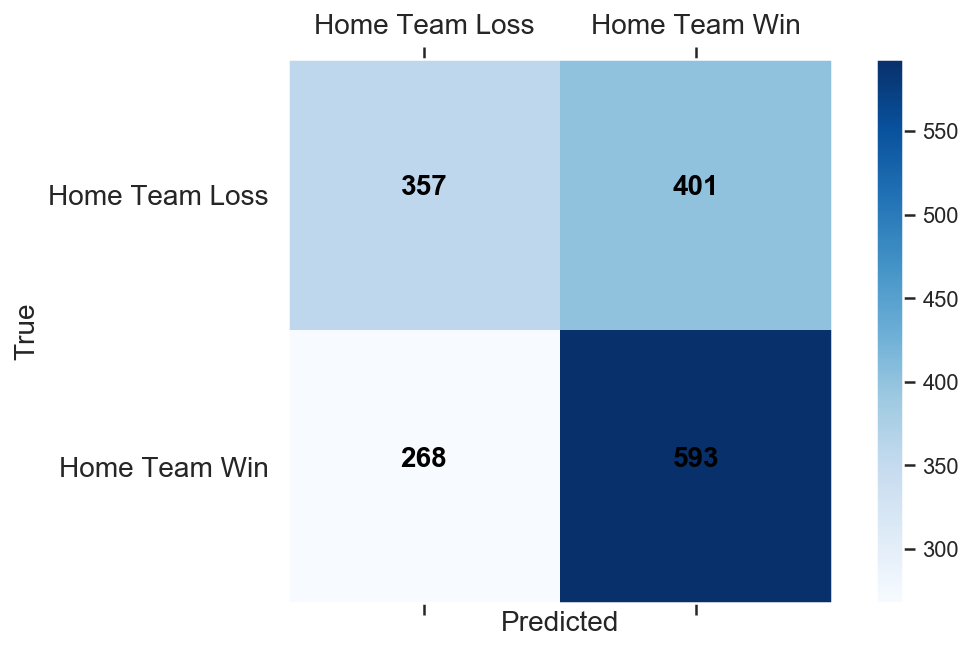

accuracy: 56.52% (+/- 1.22%)
precision: 58.16% (+/- 1.09%)
recall: 67.44% (+/- 1.03%)
f1 score: 62.46% (+/- 1.05%)
roc_auc score: 56.52% (+/- 1.22%)


In [139]:
pipeline_cv(3,X,y,lr_random_search)

In [140]:
lr_random_search.best_params_

{'zero_imputer__strategy': 'median',
 'scaler__with_std': True,
 'scaler__with_mean': True,
 'nan_imputer__strategy': 'most_frequent',
 'classifier__solver': 'liblinear',
 'classifier__penalty': 'l1',
 'classifier__max_iter': 1000,
 'classifier__intercept_scaling': 0.5285714285714286,
 'classifier__C': 1.6571428571428573,
 'attr_adder__add_hitters_slashInteraction': True}

##### grid search logistic regression 

In [141]:
lr_grid_search_params = {
    'zero_imputer__strategy':['most_frequent'],
    'nan_imputer__strategy':['mean'],
    'interaction__degree':[1],
    'scaler__with_std':[False],
    'scaler__with_mean':[False],
    'classifier__solver':['liblinear'],
    'classifier__penalty':['l2'],
    'classifier__intercept_scaling':[.4],
    'classifier__max_iter':[1000],
    'classifier__C':[3.48]
}

In [142]:
lr_grid_search = GridSearchCV(lr_pipe,lr_grid_search_params,cv=5,n_jobs=-1,scoring=auc_scorer,verbose=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.604878,0.601423,0.602881,0.603151,0.603101
recall,0.525424,0.676000,0.602881,0.600712,0.602881
f1-score,0.562358,0.636535,0.602881,0.599447,0.600515
support,472.000000,500.000000,0.602881,972.000000,972.000000


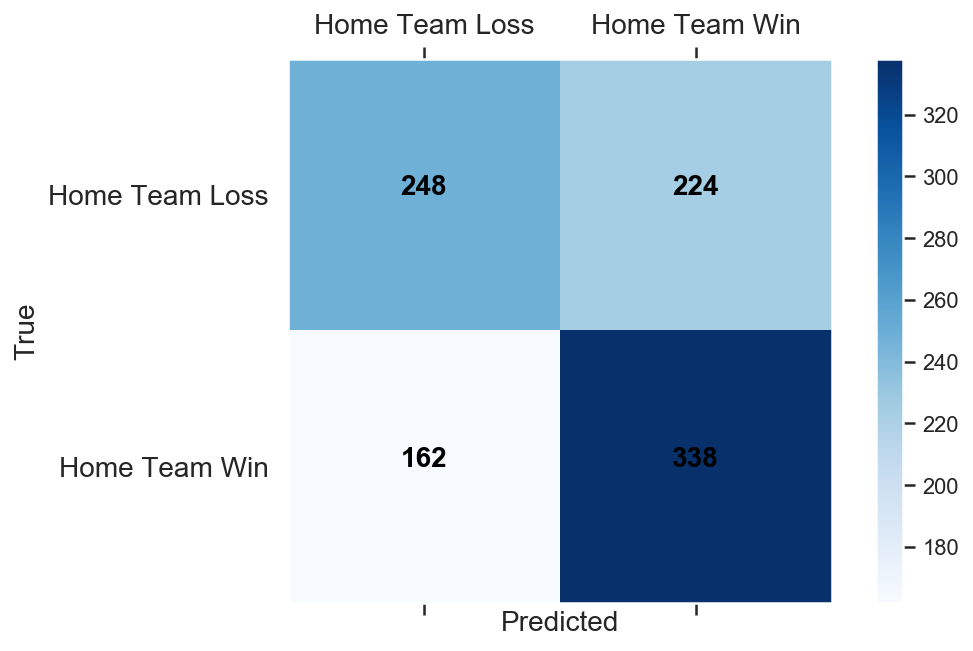

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.530184,0.578680,0.559671,0.554432,0.556178
recall,0.447894,0.656430,0.559671,0.552162,0.559671
f1-score,0.485577,0.615108,0.559671,0.550342,0.555007
support,451.000000,521.000000,0.559671,972.000000,972.000000


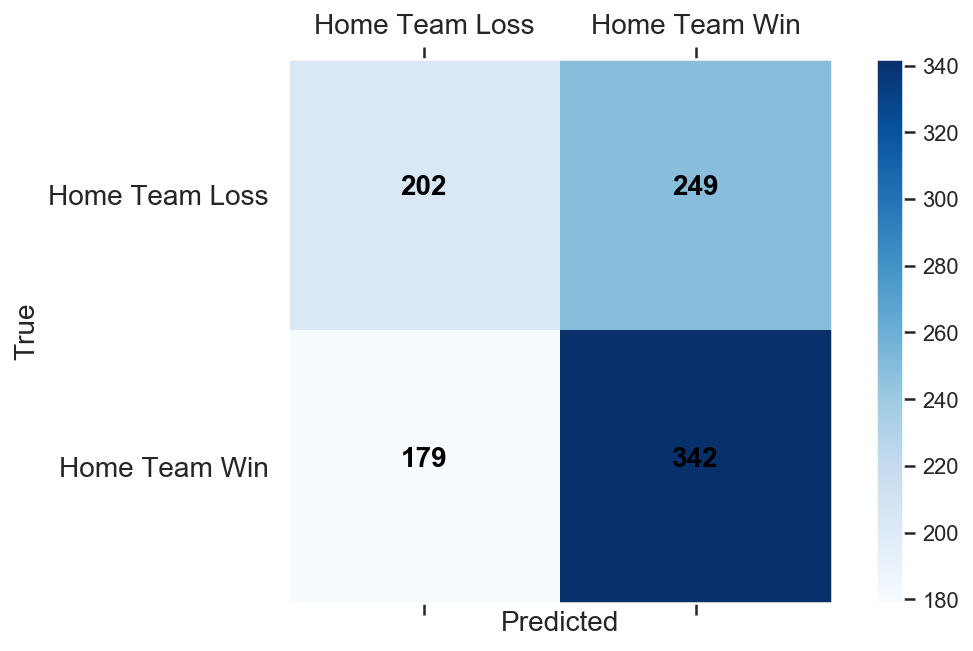

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.542466,0.574959,0.562757,0.558712,0.559715
recall,0.434211,0.676357,0.562757,0.555284,0.562757
f1-score,0.482339,0.621549,0.562757,0.551944,0.556241
support,456.000000,516.000000,0.562757,972.000000,972.000000


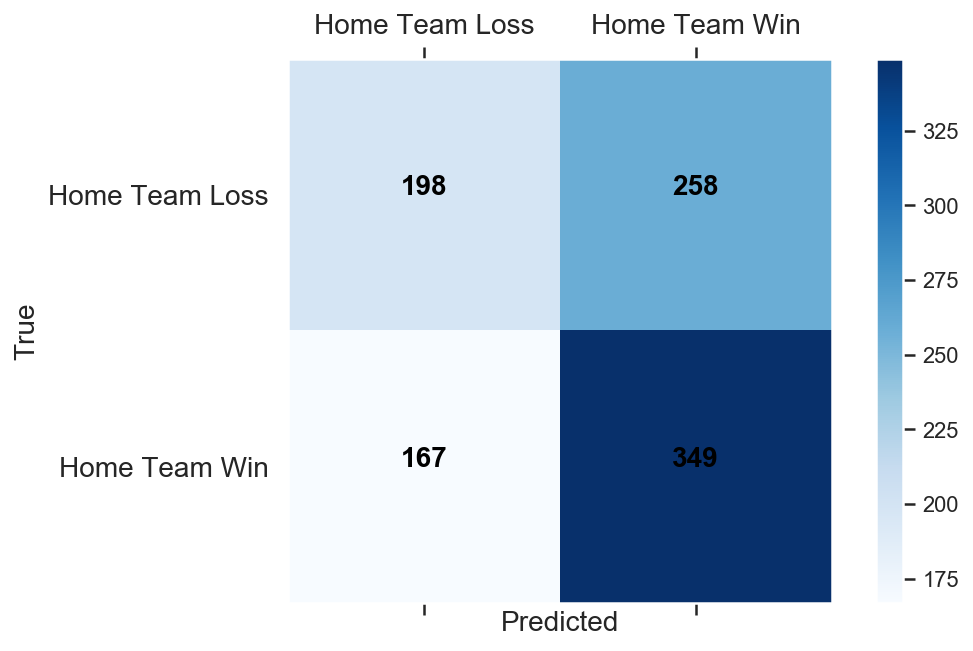

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.572603,0.588138,0.582305,0.580371,0.580802
recall,0.455338,0.695906,0.582305,0.575622,0.582305
f1-score,0.507282,0.637500,0.582305,0.572391,0.576008
support,459.000000,513.000000,0.582305,972.000000,972.000000


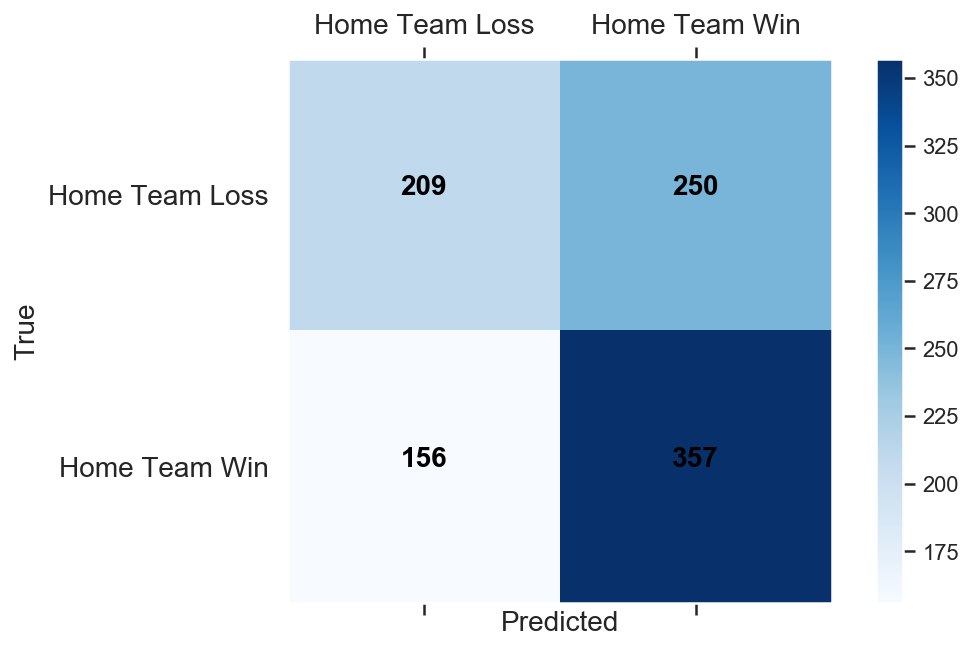

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/panda

,0,1,accuracy,macro avg,weighted avg
precision,0.551724,0.587542,0.573635,0.569633,0.570832
recall,0.459161,0.673745,0.573635,0.566453,0.573635
f1-score,0.501205,0.627698,0.573635,0.564451,0.568685
support,453.000000,518.000000,0.573635,971.000000,971.000000


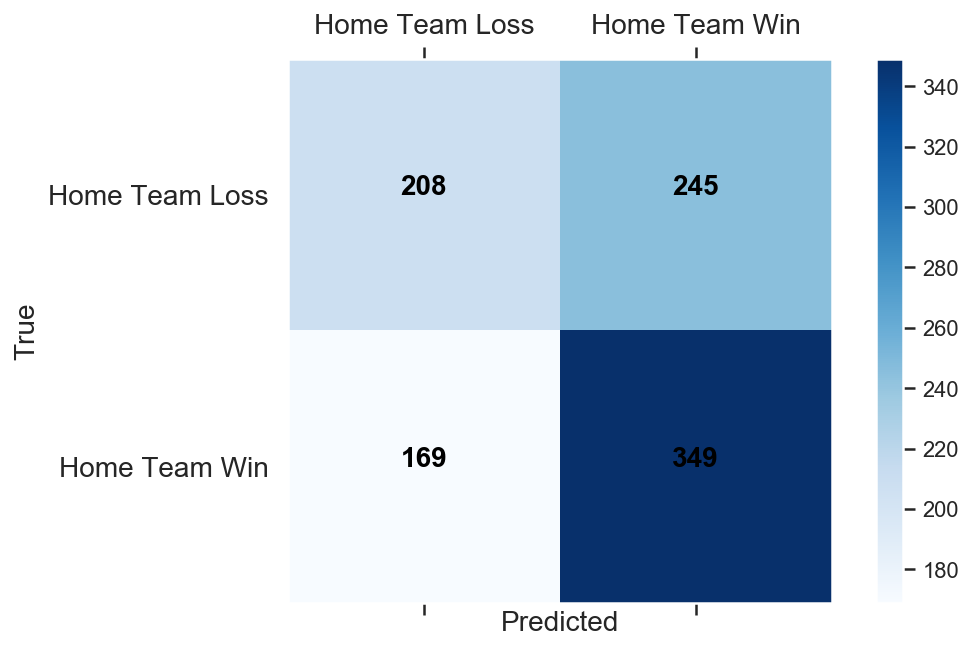

accuracy: 57.00% (+/- 1.74%)
precision: 58.61% (+/- 0.92%)
recall: 67.57% (+/- 1.25%)
f1 score: 62.77% (+/- 0.86%)
roc_auc score: 57.00% (+/- 1.74%)


In [143]:
pipeline_cv(5,X,y,lr_grid_search)

In [146]:
lr_grid_search.best_params_

{'classifier__C': 3.48,
 'classifier__intercept_scaling': 0.4,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear',
 'interaction__degree': 1,
 'nan_imputer__strategy': 'mean',
 'scaler__with_mean': False,
 'scaler__with_std': False,
 'zero_imputer__strategy': 'most_frequent'}

In [147]:
lr_auc=lr_grid_search.best_estimator_

In [ ]:
coef_dict = {}
for coef, feat in zip(lr_estimator_classifier.coef_[0,:],list(X)):
    coef_dict[feat] = coef

coef_dict

In [149]:
dummy

WinPercentageClassifier()

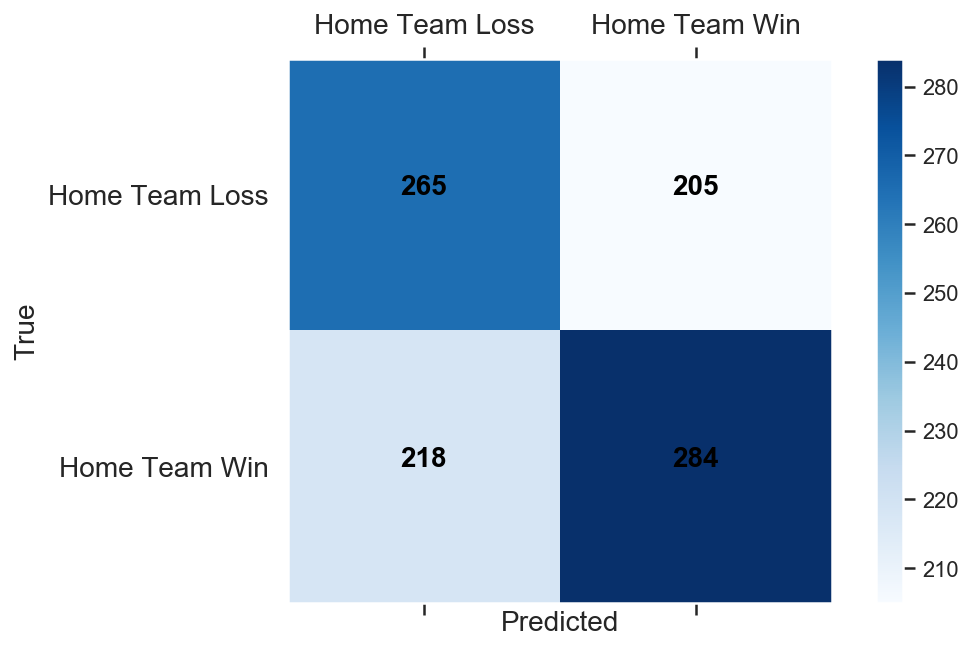

In [156]:
plot_confusion_matrix(y_test,dummy_preds)

### Random Forest Classifier

In [70]:
rf_clf = RandomForestClassifier(n_jobs=-1)

rf_pipe=Pipeline([
    ('attr_adder',CombinedAttributesAdder()),
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',rf_clf))
])

#pipeline_cv(5,X,y,rf_pipe)

In [122]:
rf_search_params = {
    'zero_imputer__strategy':['mean','median'],
    'attr_adder__add_hitters_slashInteraction':[True],
    'nan_imputer__strategy':['mean','median'],
    'interaction__degree':[1],
    'scaler__with_std':[False],
    'scaler__with_mean':[True],
    'classifier__n_estimators':list(range(110,120)),
    'classifier__criterion':['gini','entropy'],
    'classifier__max_depth':np.linspace(20,30,5),
    'classifier__min_samples_split':np.linspace(0.03, .04, 10, endpoint=True),
    'classifier__min_samples_leaf':np.linspace(0.2, 0.3, 5, endpoint=True),
    'classifier__max_features':list(range(80,90))
}

In [123]:
rf_search = RandomizedSearchCV(rf_pipe,rf_search_params,cv=5,n_jobs=-1,scoring=auc_scorer,verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.613559,0.570162,0.583333,0.591861,0.591236
recall,0.383475,0.772000,0.583333,0.577737,0.583333
f1-score,0.471969,0.655905,0.583333,0.563937,0.566586
support,472.000000,500.000000,0.583333,972.000000,972.000000


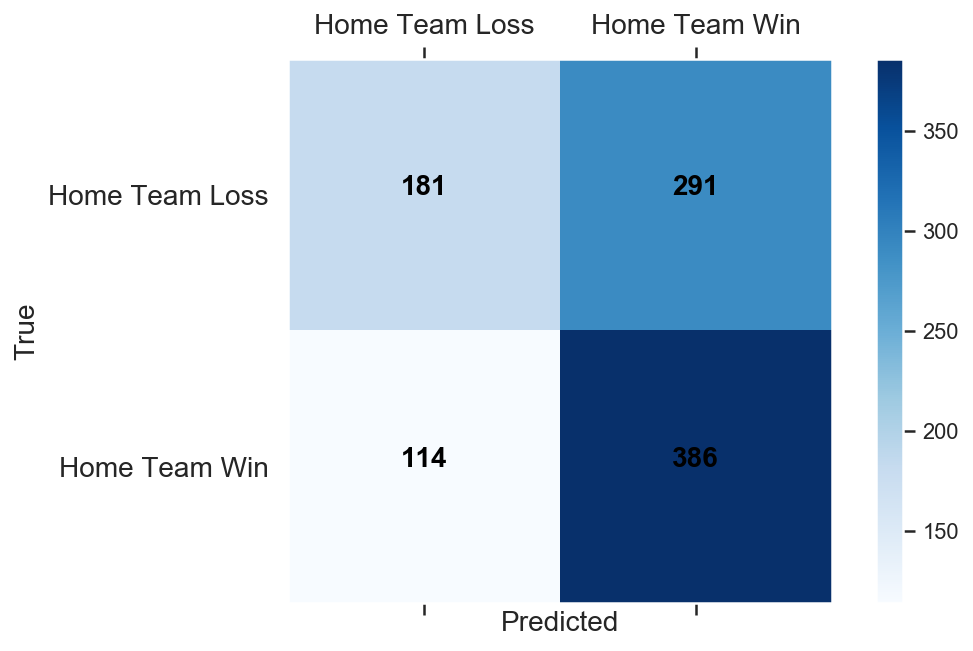

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.2s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.559078,0.588800,0.578189,0.573939,0.575009
recall,0.430155,0.706334,0.578189,0.568245,0.578189
f1-score,0.486216,0.642234,0.578189,0.564225,0.569843
support,451.000000,521.000000,0.578189,972.000000,972.000000


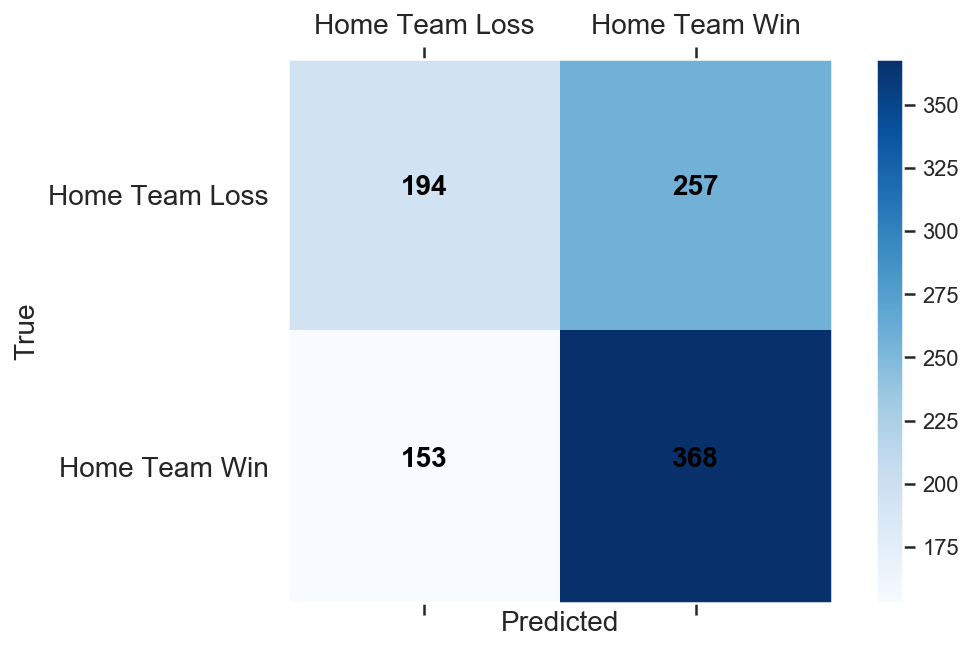

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.1s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.580508,0.566576,0.569959,0.573542,0.573112
recall,0.300439,0.808140,0.569959,0.554289,0.569959
f1-score,0.395954,0.666134,0.569959,0.531044,0.539383
support,456.000000,516.000000,0.569959,972.000000,972.000000


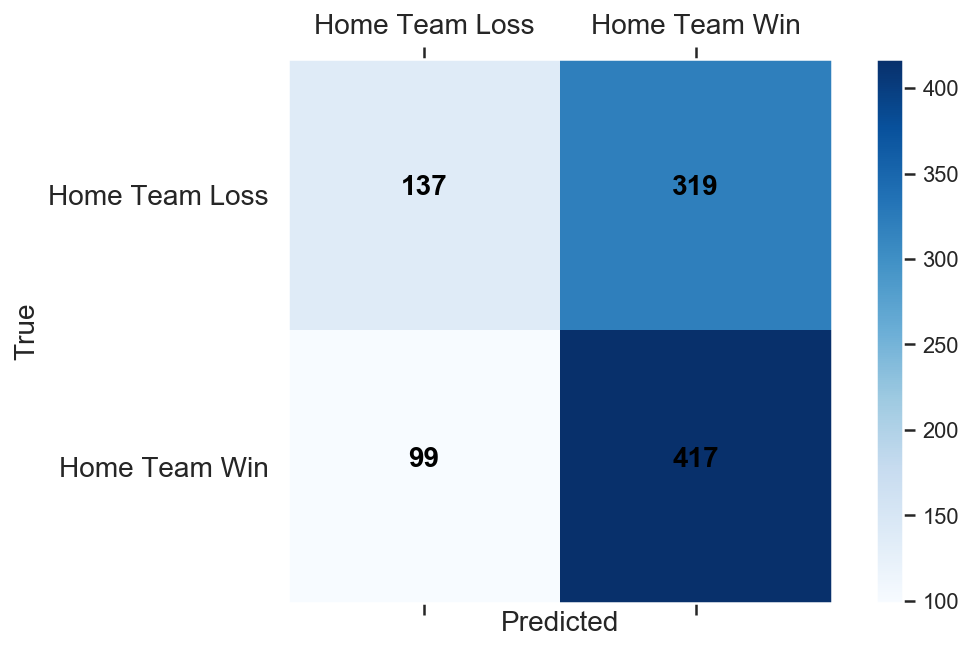

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.0s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.533816,0.573477,0.556584,0.553647,0.554748
recall,0.481481,0.623782,0.556584,0.552632,0.556584
f1-score,0.506300,0.597572,0.556584,0.551936,0.554472
support,459.000000,513.000000,0.556584,972.000000,972.000000


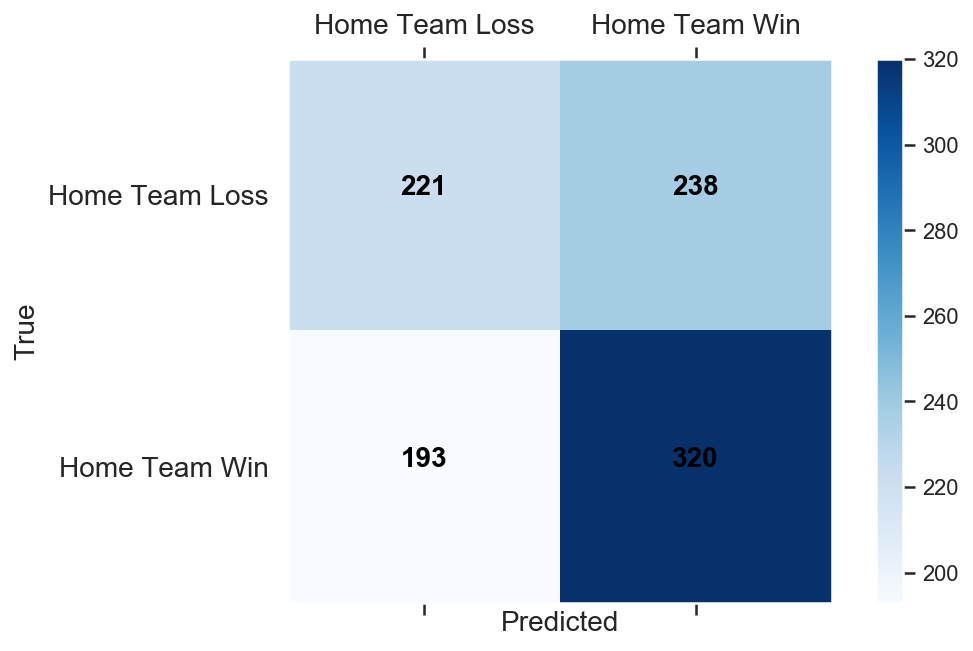

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info

,0,1,accuracy,macro avg,weighted avg
precision,0.568106,0.579104,0.575695,0.573605,0.573974
recall,0.377483,0.749035,0.575695,0.563259,0.575695
f1-score,0.453581,0.653199,0.575695,0.553390,0.560071
support,453.000000,518.000000,0.575695,971.000000,971.000000


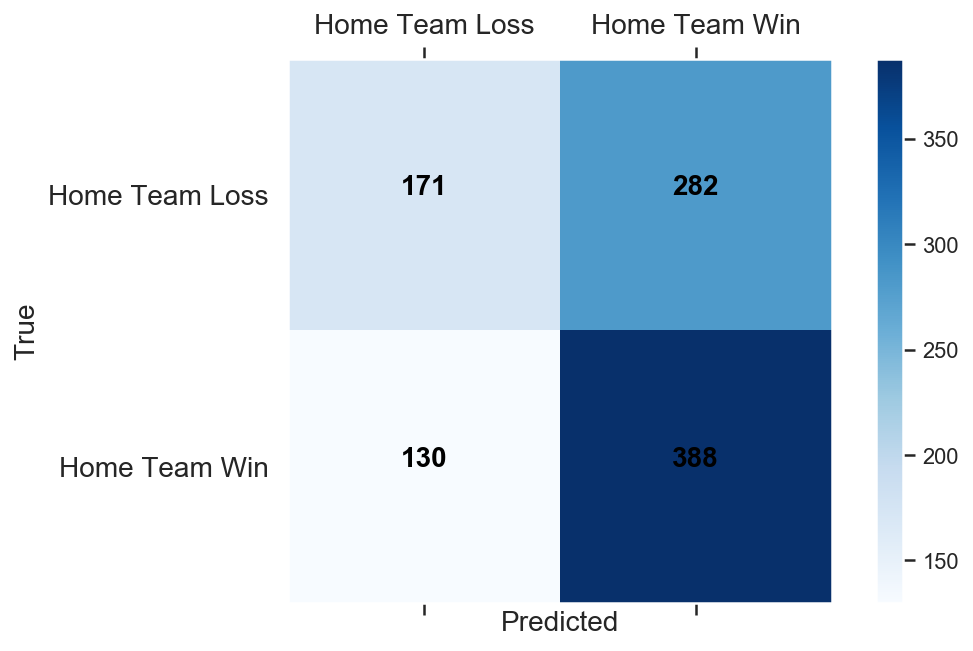

accuracy: 56.32% (+/- 0.93%)
precision: 57.56% (+/- 0.78%)
recall: 73.19% (+/- 6.33%)
f1 score: 64.30% (+/- 2.40%)
roc_auc score: 56.32% (+/- 0.93%)


In [124]:
pipeline_cv(5,X,y,rf_search)

In [125]:
rf_search.best_params_

{'zero_imputer__strategy': 'median',
 'scaler__with_std': False,
 'scaler__with_mean': True,
 'nan_imputer__strategy': 'mean',
 'interaction__degree': 1,
 'classifier__n_estimators': 115,
 'classifier__min_samples_split': 0.03111111111111111,
 'classifier__min_samples_leaf': 0.25,
 'classifier__max_features': 86,
 'classifier__max_depth': 22.5,
 'classifier__criterion': 'entropy',
 'attr_adder__add_hitters_slashInteraction': True}

In [176]:
rf_grid_search_params = {
    'zero_imputer__strategy':['mean'],
    'nan_imputer__strategy':['median'],
    'attr_adder__add_hitters_slashInteraction':[True],
    'interaction__degree':[1],
    'scaler__with_std':[True],
    'scaler__with_mean':[False],
    'classifier__n_estimators':[135],
    'classifier__criterion':['gini'],
    'classifier__max_depth':[8],
    'classifier__min_samples_split':[.19],
    'classifier__min_samples_leaf':[.08,.09,.1],
    'classifier__max_features':[65]
}

In [177]:
rf_grid_search = GridSearchCV(rf_pipe,rf_grid_search_params,cv=5,n_jobs=-1,scoring=f1_scorer,verbose=1)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    7.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.5s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_

,0,1,accuracy,macro avg,weighted avg
precision,0.600000,0.578778,0.58642,0.589389,0.589083
recall,0.444915,0.720000,0.58642,0.582458,0.586420
f1-score,0.510949,0.641711,0.58642,0.576330,0.578213
support,472.000000,500.000000,0.58642,972.000000,972.000000


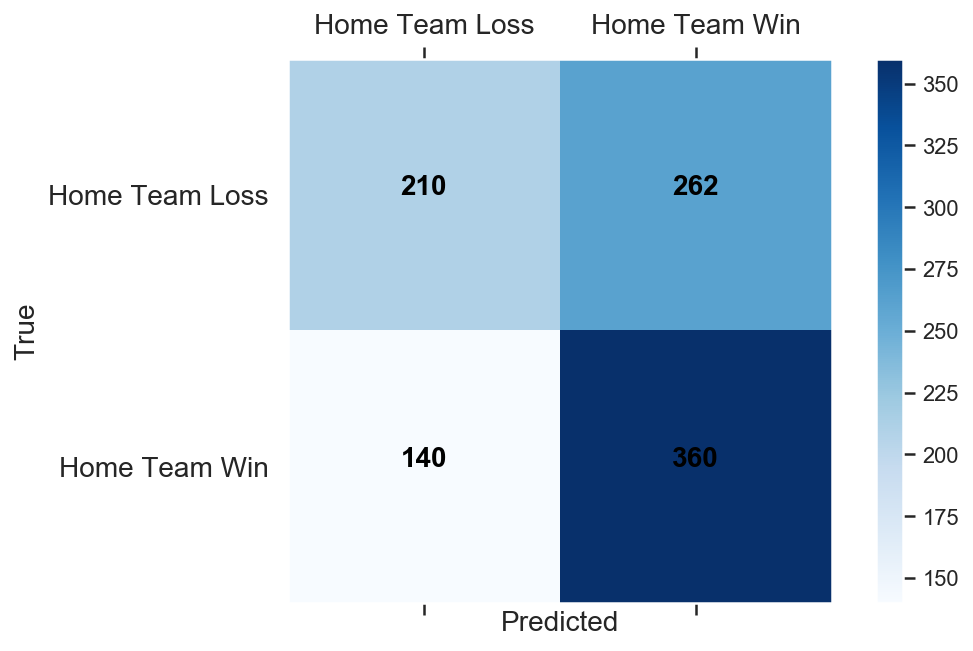

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.8s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_

,0,1,accuracy,macro avg,weighted avg
precision,0.561290,0.581571,0.575103,0.571431,0.572161
recall,0.385809,0.738964,0.575103,0.562386,0.575103
f1-score,0.457293,0.650888,0.575103,0.554090,0.561061
support,451.000000,521.000000,0.575103,972.000000,972.000000


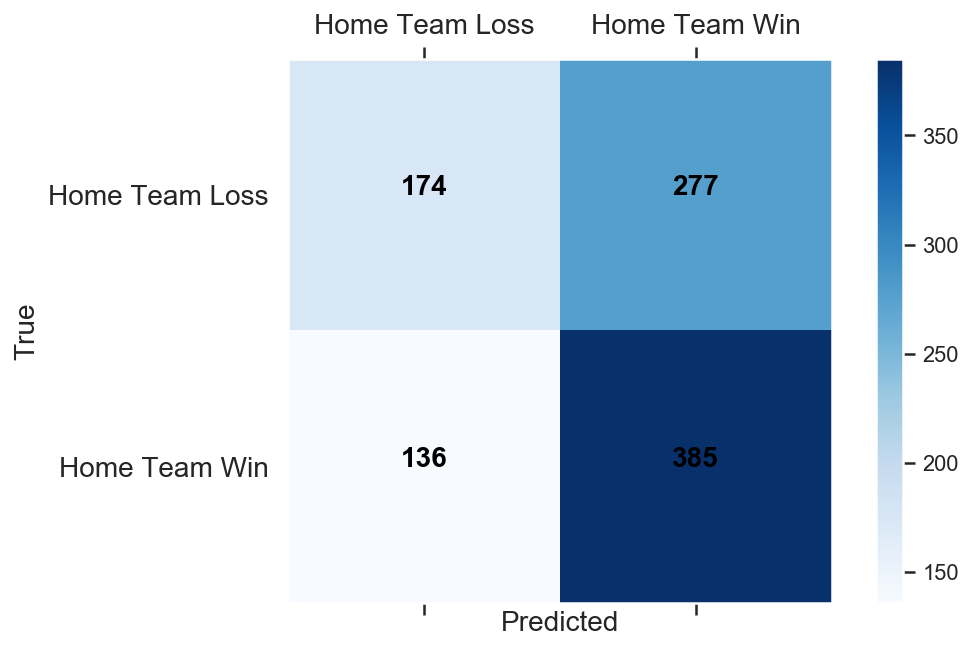

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.3s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.8s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_

,0,1,accuracy,macro avg,weighted avg
precision,0.553247,0.586031,0.573045,0.569639,0.570651
recall,0.467105,0.666667,0.573045,0.566886,0.573045
f1-score,0.506540,0.623753,0.573045,0.565147,0.568764
support,456.000000,516.000000,0.573045,972.000000,972.000000


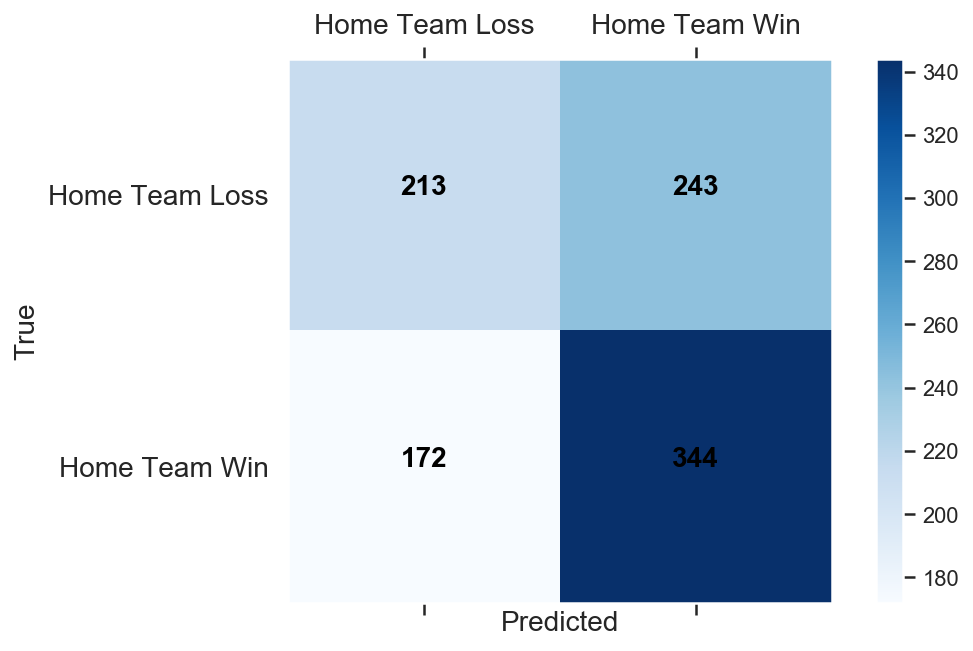

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.8s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_

,0,1,accuracy,macro avg,weighted avg
precision,0.564263,0.572741,0.569959,0.568502,0.568738
recall,0.392157,0.729045,0.569959,0.560601,0.569959
f1-score,0.462725,0.641509,0.569959,0.552117,0.557083
support,459.000000,513.000000,0.569959,972.000000,972.000000


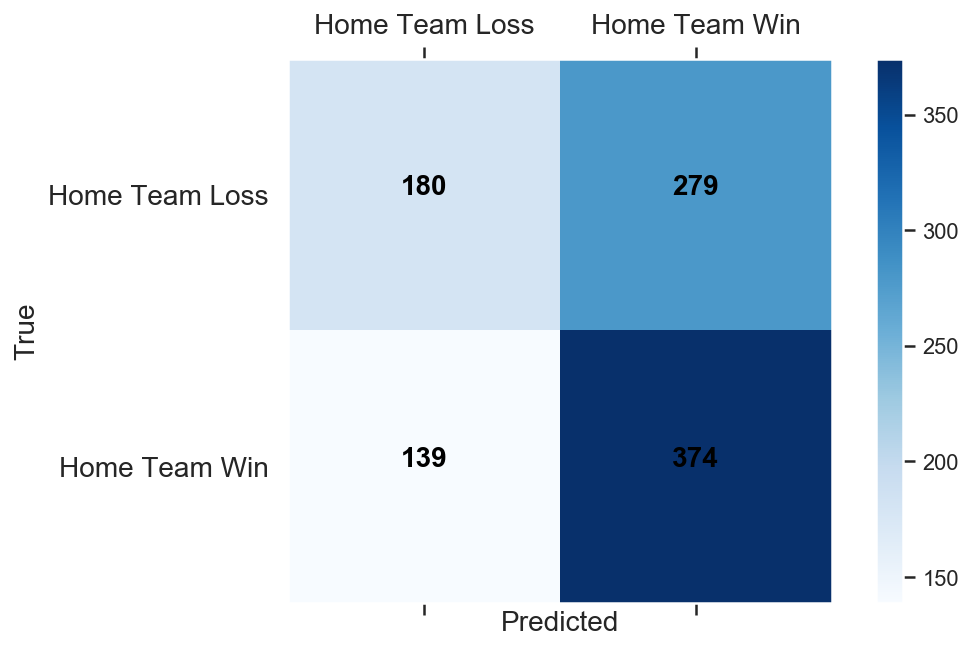

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.0s finished
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_

,0,1,accuracy,macro avg,weighted avg
precision,0.563798,0.585174,0.577755,0.574486,0.575201
recall,0.419426,0.716216,0.577755,0.567821,0.577755
f1-score,0.481013,0.644097,0.577755,0.562555,0.568013
support,453.000000,518.000000,0.577755,971.000000,971.000000


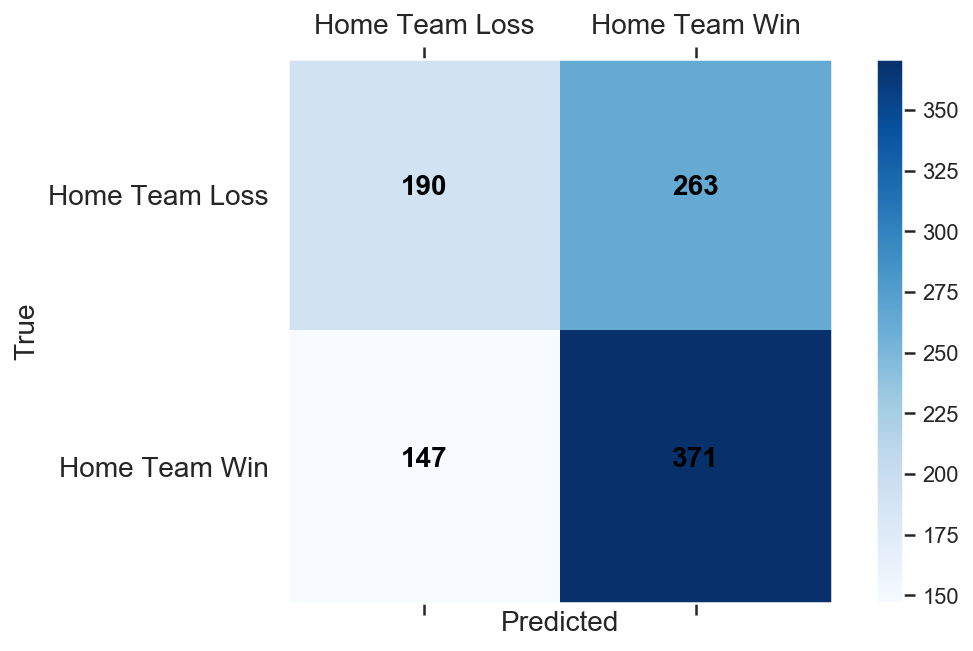

accuracy: 56.66% (+/- 0.72%)
precision: 58.09% (+/- 0.48%)
recall: 71.42% (+/- 2.50%)
f1 score: 64.04% (+/- 0.90%)
roc_auc score: 56.80% (+/- 0.77%)


In [178]:
pipeline_cv(5,X,y,rf_grid_search)

In [130]:
rf_grid_search.best_params_

{'attr_adder__add_hitters_slashInteraction': True,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 8,
 'classifier__max_features': 65,
 'classifier__min_samples_leaf': 0.08,
 'classifier__min_samples_split': 0.19,
 'classifier__n_estimators': 135,
 'interaction__degree': 1,
 'nan_imputer__strategy': 'median',
 'scaler__with_mean': False,
 'scaler__with_std': True,
 'zero_imputer__strategy': 'mean'}

In [179]:
rf_f1=rf_grid_search.best_estimator_

### Gradient Boost

In [163]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_pipe=Pipeline([
    ('nan_imputer',SimpleImputer(strategy='mean')),
    ('zero_imputer',SimpleImputer(missing_values=0,strategy='mean')),
    ('interaction',PolynomialFeatures(degree=1)),
    ('scaler',StandardScaler()),
    (('classifier',gb_clf))
])

#pipeline_cv(5,X,y,gb_pipe)

In [189]:
gb_search_params = {
    'zero_imputer__strategy':['mean','median','most_frequent'],
    'nan_imputer__strategy':['mean','median','most_frequent'],
    'interaction__degree':[1],
    'scaler__with_std':[False,True],
    'scaler__with_mean':[True,False],
    'classifier__n_estimators':[100,105,110],
    'classifier__loss':['deviance','exponential'],
    'classifier__max_depth':[1,2,3],
    'classifier__min_samples_split':np.linspace(0.3, .6, 5, endpoint=True),
    'classifier__min_samples_leaf':np.linspace(0.2, 0.5, 5, endpoint=True),
    'classifier__max_features':[70,80,90],
    'classifier__learning_rate':np.linspace(.5,.7,8,endpoint=True)
}

In [196]:
gb_search = RandomizedSearchCV(gb_pipe,gb_search_params,cv=5,n_jobs=-1,scoring=precision_scorer,verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.8s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.592233,0.592857,0.592593,0.592545,0.592554
recall,0.516949,0.664000,0.592593,0.590475,0.592593
f1-score,0.552036,0.626415,0.592593,0.589226,0.590297
support,472.000000,500.000000,0.592593,972.000000,972.000000


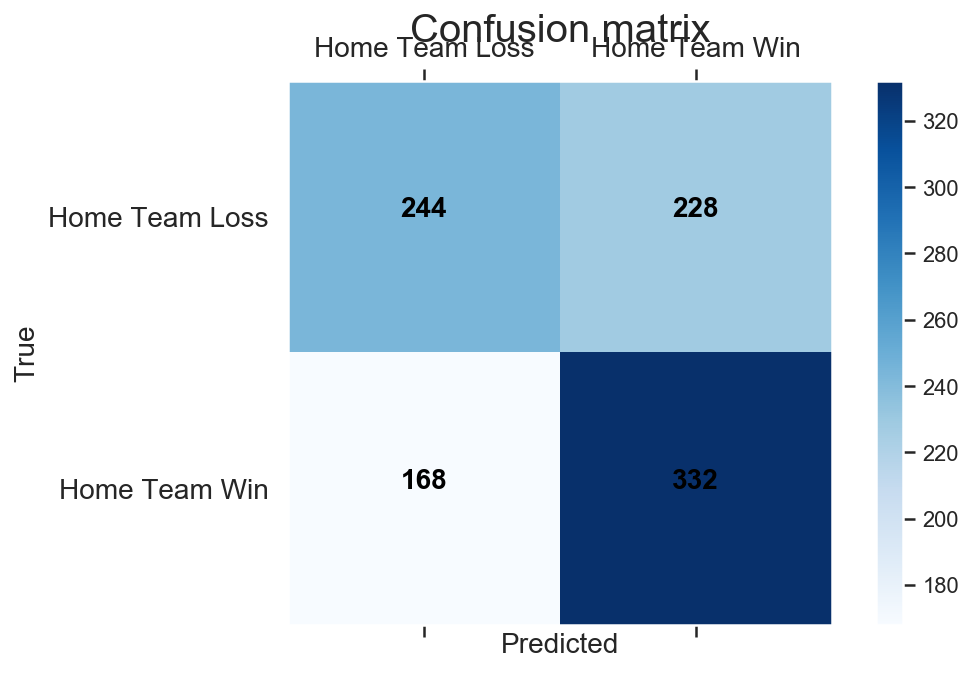

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.2s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.546366,0.593368,0.574074,0.569867,0.571560
recall,0.483370,0.652591,0.574074,0.567981,0.574074
f1-score,0.512941,0.621572,0.574074,0.567257,0.571168
support,451.000000,521.000000,0.574074,972.000000,972.000000


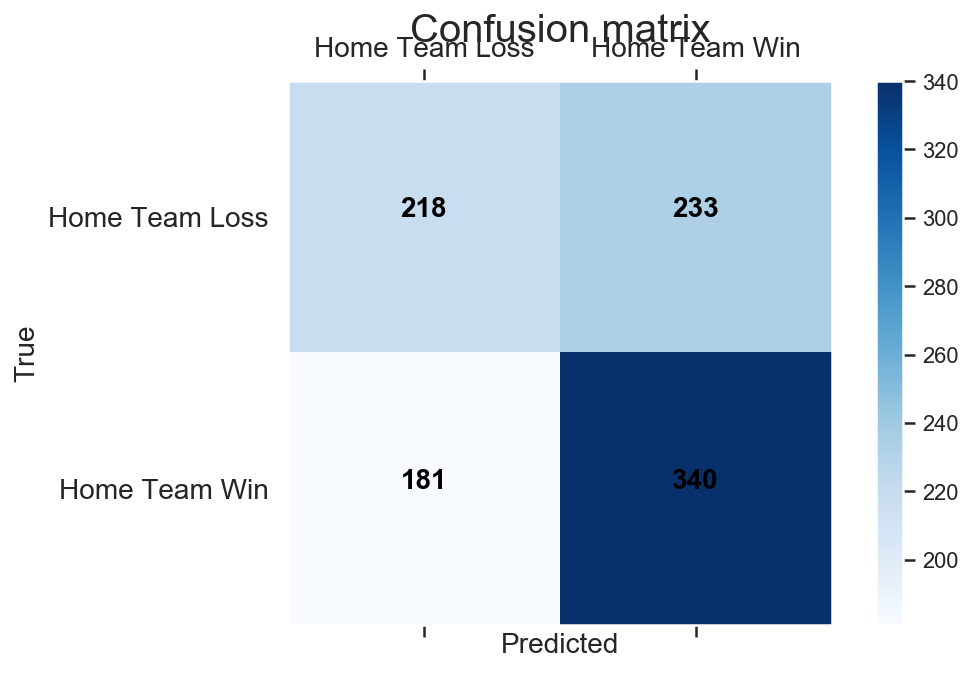

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.3s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.515663,0.565530,0.544239,0.540596,0.542135
recall,0.469298,0.610465,0.544239,0.539882,0.544239
f1-score,0.491389,0.587139,0.544239,0.539264,0.542219
support,456.000000,516.000000,0.544239,972.000000,972.000000


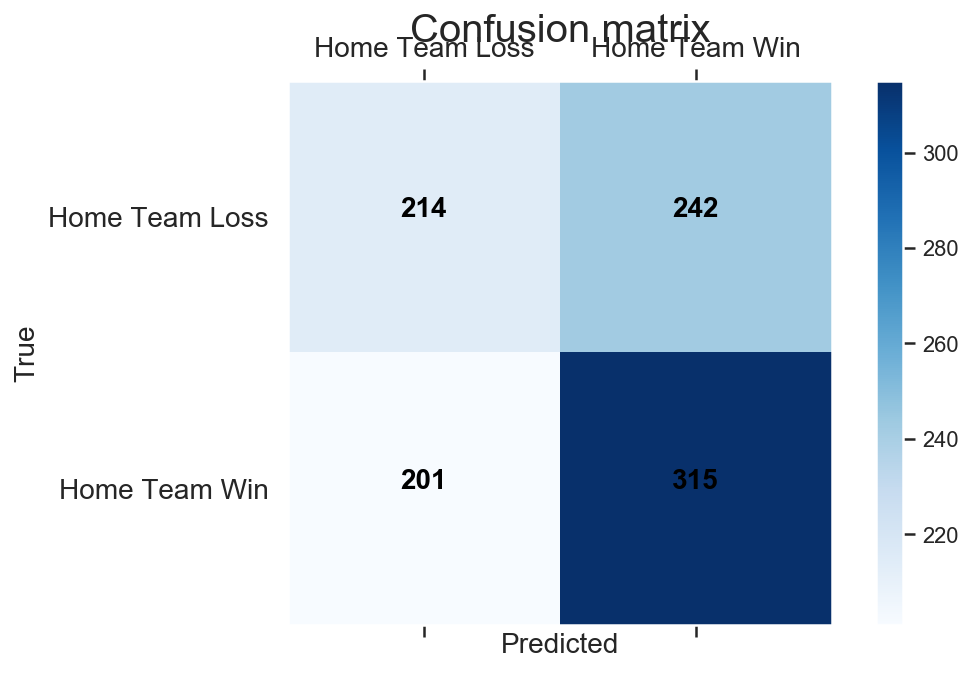

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.535519,0.566007,0.554527,0.550763,0.551610
recall,0.427015,0.668616,0.554527,0.547816,0.554527
f1-score,0.475152,0.613047,0.554527,0.544099,0.547930
support,459.000000,513.000000,0.554527,972.000000,972.000000


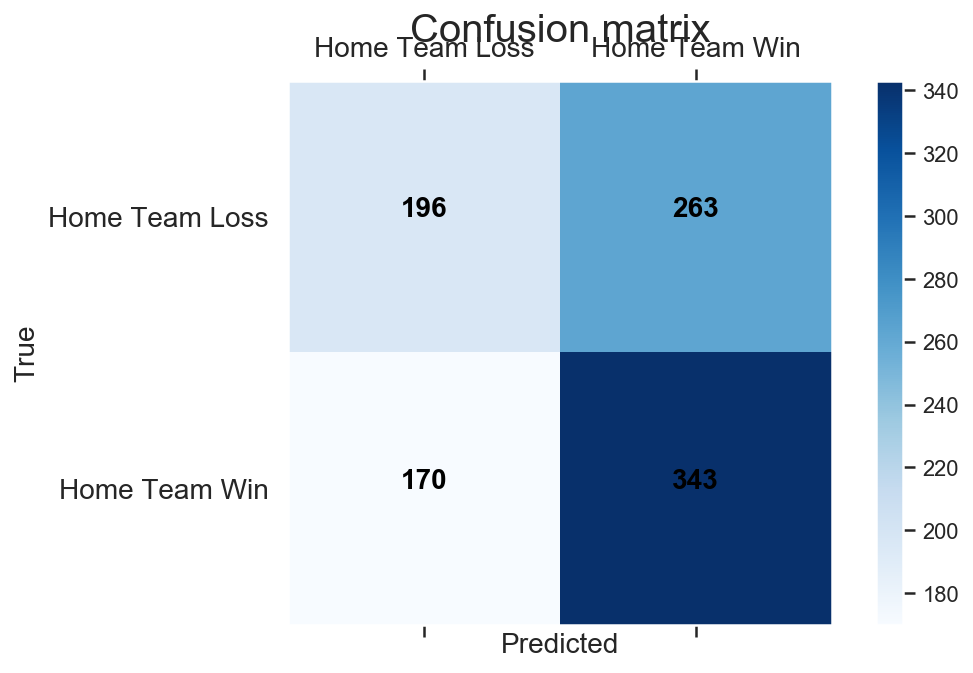

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.9s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.550505,0.591304,0.574665,0.570905,0.572270
recall,0.481236,0.656371,0.574665,0.568803,0.574665
f1-score,0.513545,0.622141,0.574665,0.567843,0.571478
support,453.000000,518.000000,0.574665,971.000000,971.000000


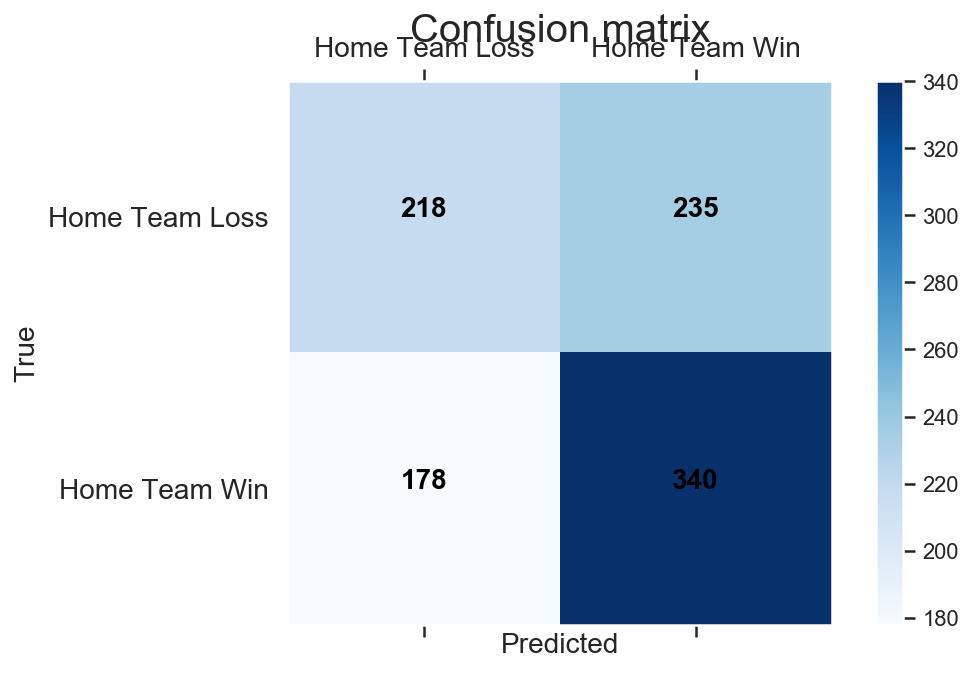

accuracy: 58.18% (+/- 1.31%)
precision: 58.18% (+/- 1.31%)
recall: 65.04% (+/- 2.07%)
f1 score: 61.41% (+/- 1.41%)
roc_auc score: 56.30% (+/- 1.78%)


In [191]:
pipeline_cv(5,X,y,gb_search)

In [192]:
gb_search.best_params_

{'zero_imputer__strategy': 'median',
 'scaler__with_std': False,
 'scaler__with_mean': True,
 'nan_imputer__strategy': 'mean',
 'interaction__degree': 1,
 'classifier__n_estimators': 105,
 'classifier__min_samples_split': 0.5249999999999999,
 'classifier__min_samples_leaf': 0.425,
 'classifier__max_features': 70,
 'classifier__max_depth': 2,
 'classifier__loss': 'deviance',
 'classifier__learning_rate': 0.6714285714285714}

In [161]:
gb_grid_search_params = {
    'zero_imputer__strategy':['median'],
    'nan_imputer__strategy':['mean'],
    'interaction__degree':[1],
    'scaler__with_std':[False],
    'scaler__with_mean':[True],
    'classifier__n_estimators':[105],
    'classifier__loss':['deviance'],
    'classifier__max_depth':[1,2,3],
    'classifier__min_samples_split':[.4,.5,.6],
    'classifier__min_samples_leaf':[.45],
    'classifier__max_features':[80],
    'classifier__learning_rate':[.65]
}

In [164]:
gb_grid_search = GridSearchCV(gb_pipe,gb_grid_search_params,cv=5,n_jobs=-1,scoring=f1_scorer,verbose=1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.3s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.593674,0.593583,0.593621,0.593628,0.593627
recall,0.516949,0.666000,0.593621,0.591475,0.593621
f1-score,0.552661,0.627710,0.593621,0.590186,0.591266
support,472.000000,500.000000,0.593621,972.000000,972.000000


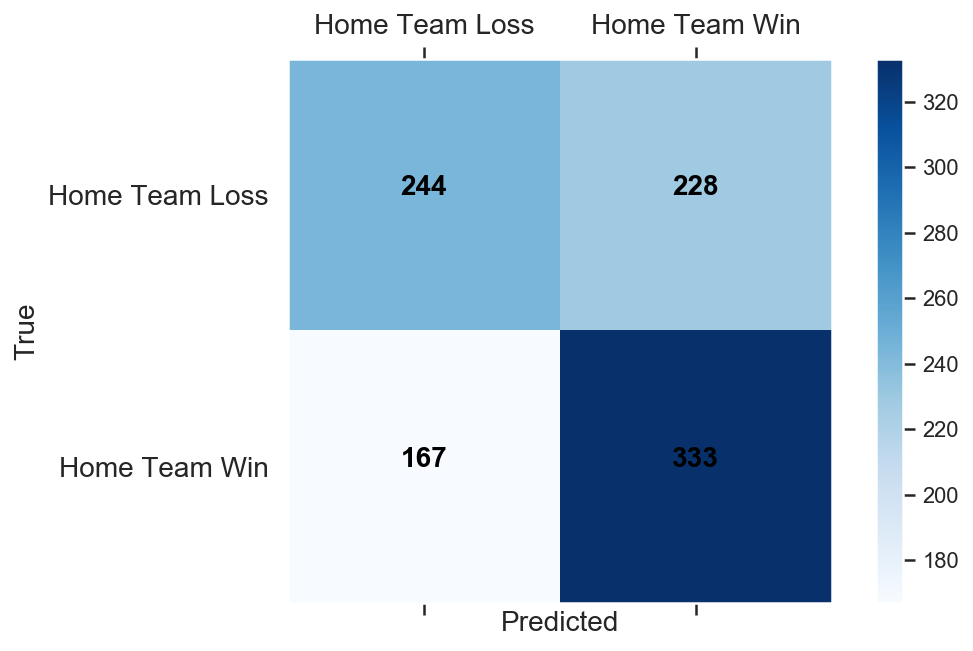

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.2s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.551813,0.593857,0.57716,0.572835,0.574349
recall,0.472284,0.667946,0.57716,0.570115,0.577160
f1-score,0.508961,0.628726,0.57716,0.568843,0.573156
support,451.000000,521.000000,0.57716,972.000000,972.000000


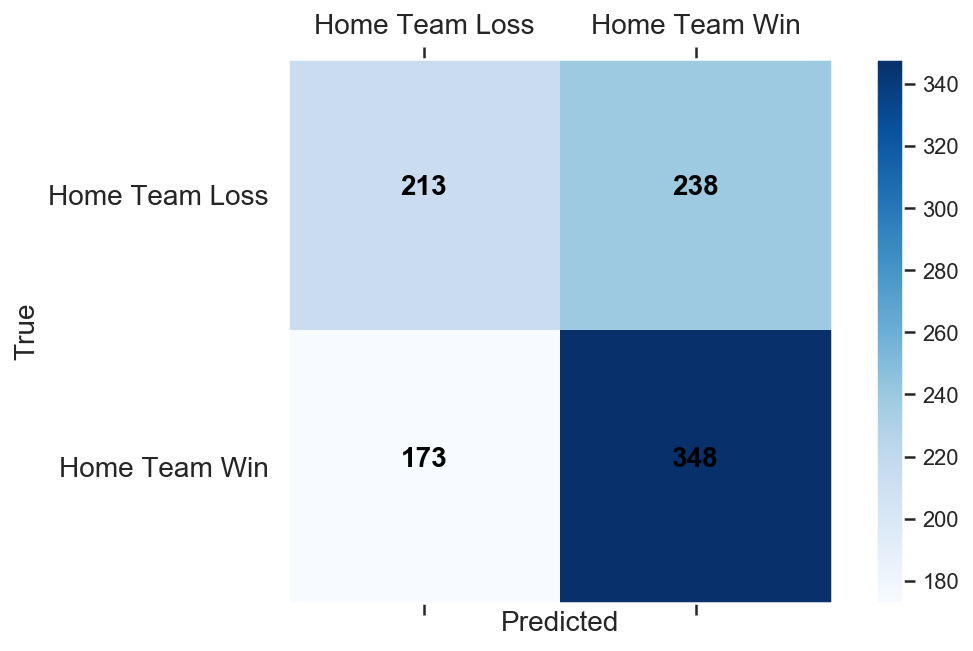

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.4s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.539241,0.578856,0.562757,0.559048,0.560271
recall,0.467105,0.647287,0.562757,0.557196,0.562757
f1-score,0.500588,0.611162,0.562757,0.555875,0.559288
support,456.000000,516.000000,0.562757,972.000000,972.000000


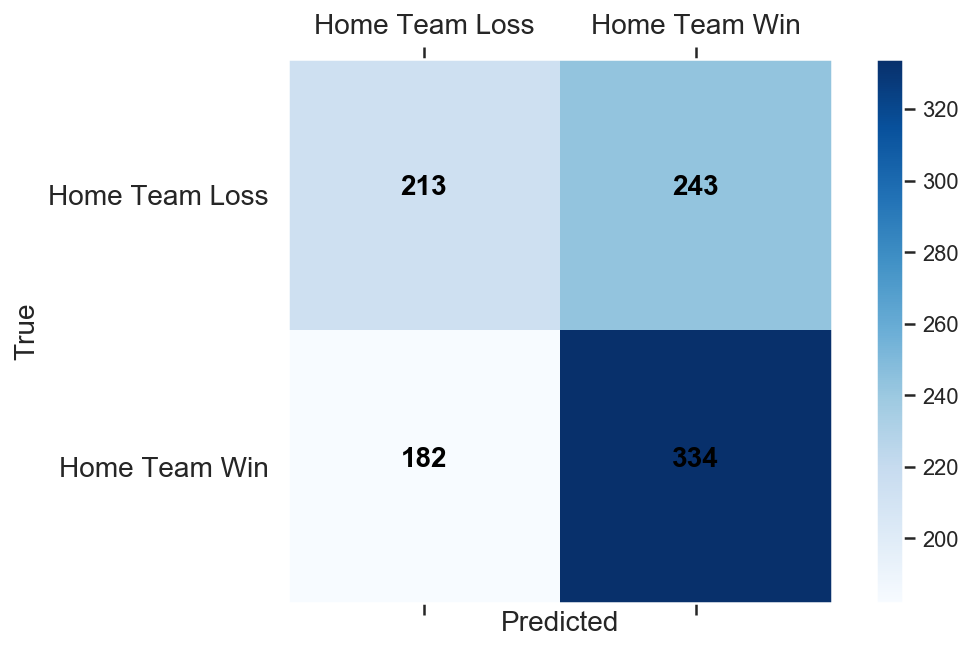

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.4s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.529570,0.563333,0.550412,0.546452,0.547389
recall,0.429194,0.658869,0.550412,0.544032,0.550412
f1-score,0.474128,0.607367,0.550412,0.540748,0.544449
support,459.000000,513.000000,0.550412,972.000000,972.000000


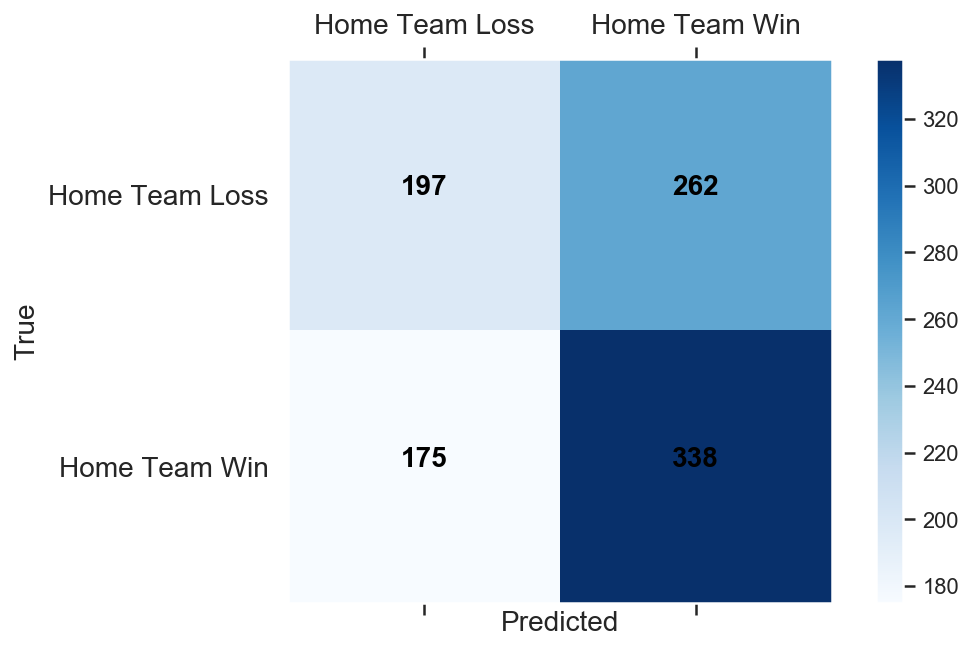

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.5s finished


,0,1,accuracy,macro avg,weighted avg
precision,0.565445,0.597623,0.584964,0.581534,0.582611
recall,0.476821,0.679537,0.584964,0.578179,0.584964
f1-score,0.517365,0.635953,0.584964,0.576659,0.580628
support,453.000000,518.000000,0.584964,971.000000,971.000000


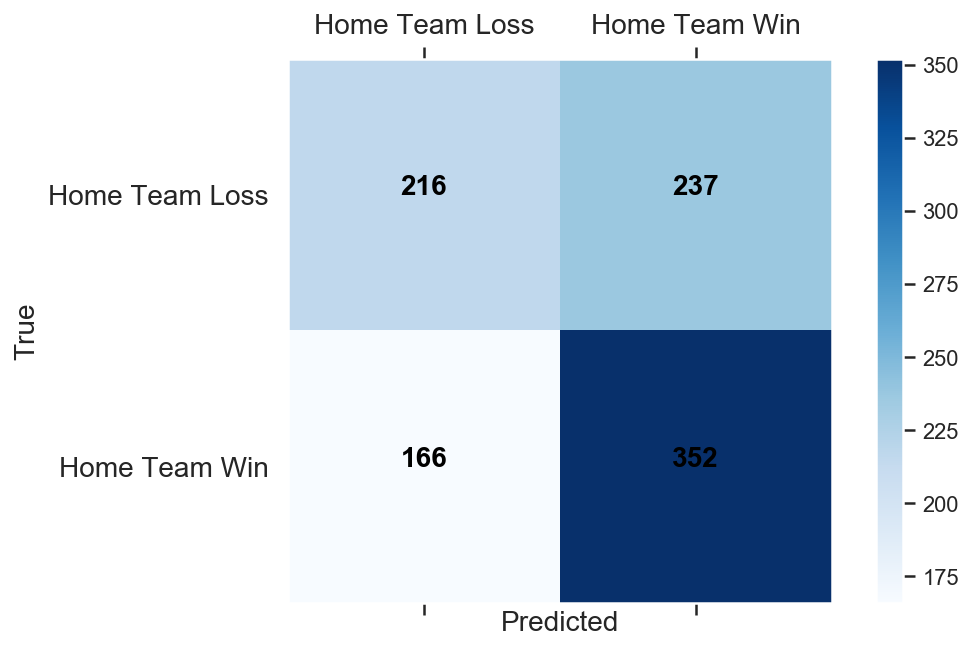

accuracy: 56.98% (+/- 1.64%)
precision: 58.55% (+/- 1.28%)
recall: 66.39% (+/- 1.06%)
f1 score: 62.22% (+/- 1.10%)
roc_auc score: 56.82% (+/- 1.64%)


In [165]:
pipeline_cv(5,X,y,gb_grid_search)

In [166]:
gb_f1= gb_grid_search.best_estimator_

### Voting / Stacking

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.627792,0.615114,0.62037,0.621453,0.621270
recall,0.536017,0.700000,0.62037,0.618008,0.620370
f1-score,0.578286,0.654818,0.62037,0.616552,0.617654
support,472.000000,500.000000,0.62037,972.000000,972.000000


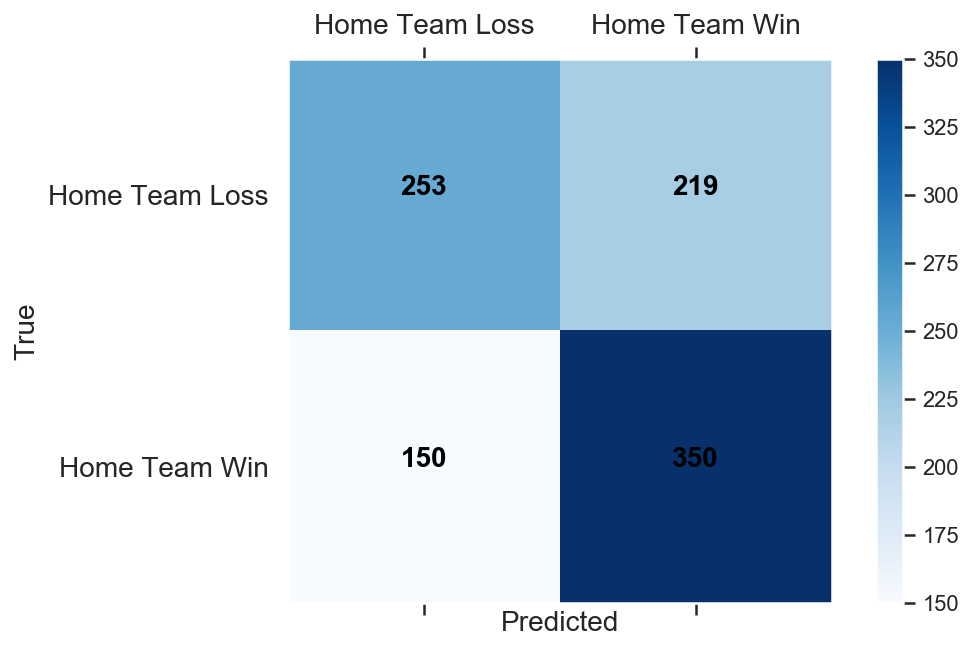

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.547945,0.586491,0.572016,0.567218,0.568606
recall,0.443459,0.683301,0.572016,0.563380,0.572016
f1-score,0.490196,0.631206,0.572016,0.560701,0.565778
support,451.000000,521.000000,0.572016,972.000000,972.000000


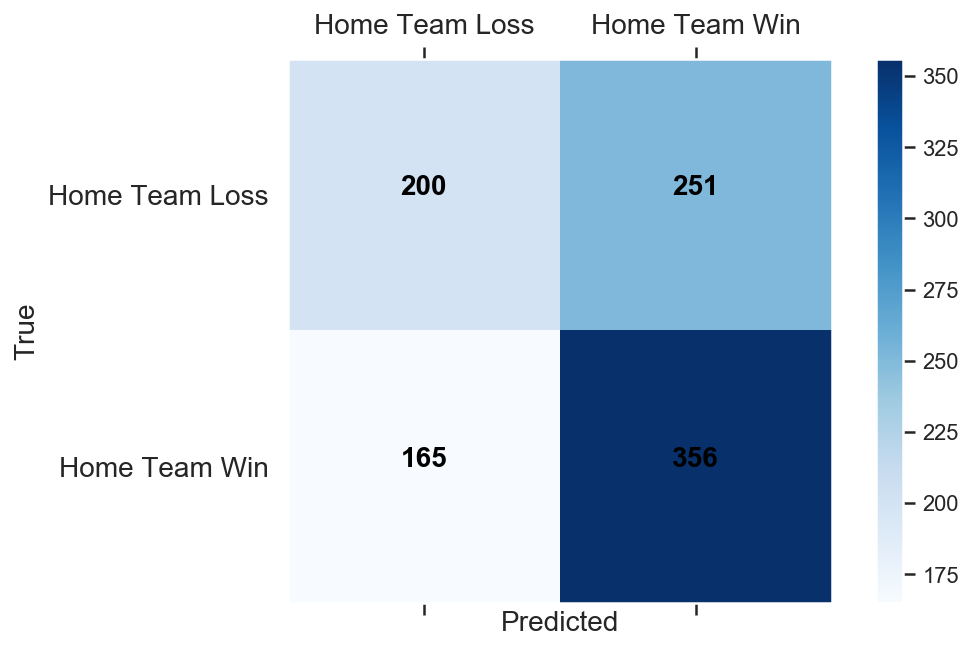

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.547684,0.578512,0.566872,0.563098,0.564050
recall,0.440789,0.678295,0.566872,0.559542,0.566872
f1-score,0.488457,0.624442,0.566872,0.556450,0.560647
support,456.000000,516.000000,0.566872,972.000000,972.000000


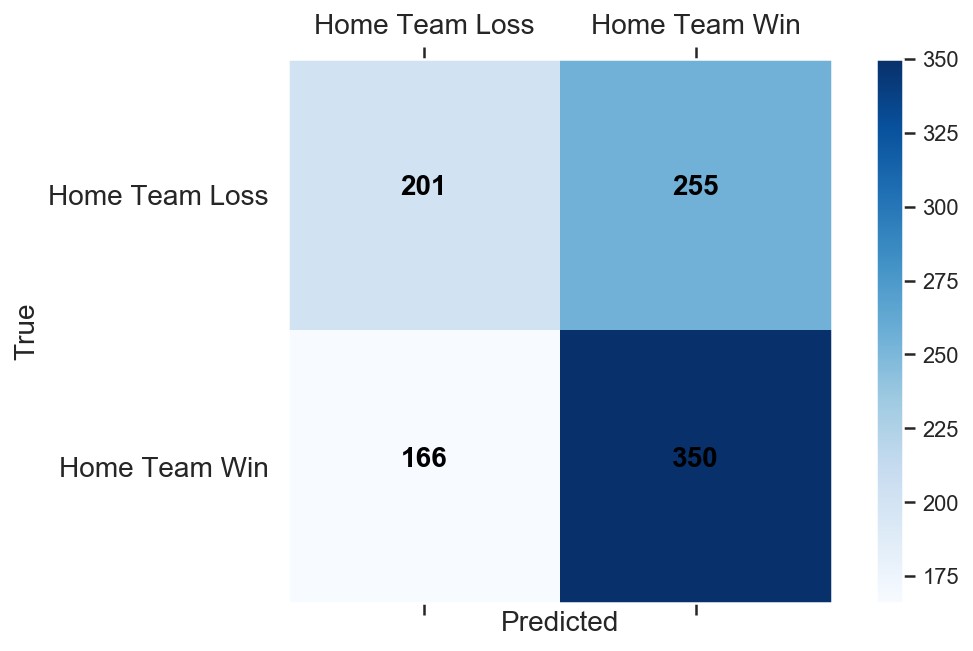

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.572674,0.582803,0.579218,0.577738,0.578020
recall,0.429194,0.713450,0.579218,0.571322,0.579218
f1-score,0.490660,0.641543,0.579218,0.566101,0.570292
support,459.000000,513.000000,0.579218,972.000000,972.000000


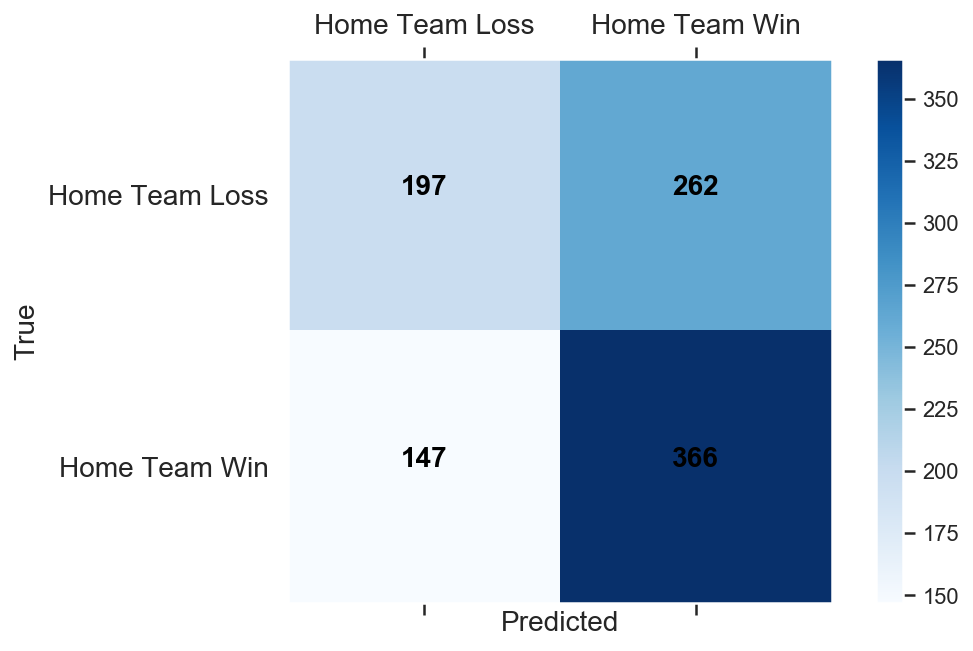

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,0,1,accuracy,macro avg,weighted avg
precision,0.569061,0.594417,0.584964,0.581739,0.582588
recall,0.454746,0.698842,0.584964,0.576794,0.584964
f1-score,0.505521,0.642413,0.584964,0.573967,0.578549
support,453.000000,518.000000,0.584964,971.000000,971.000000


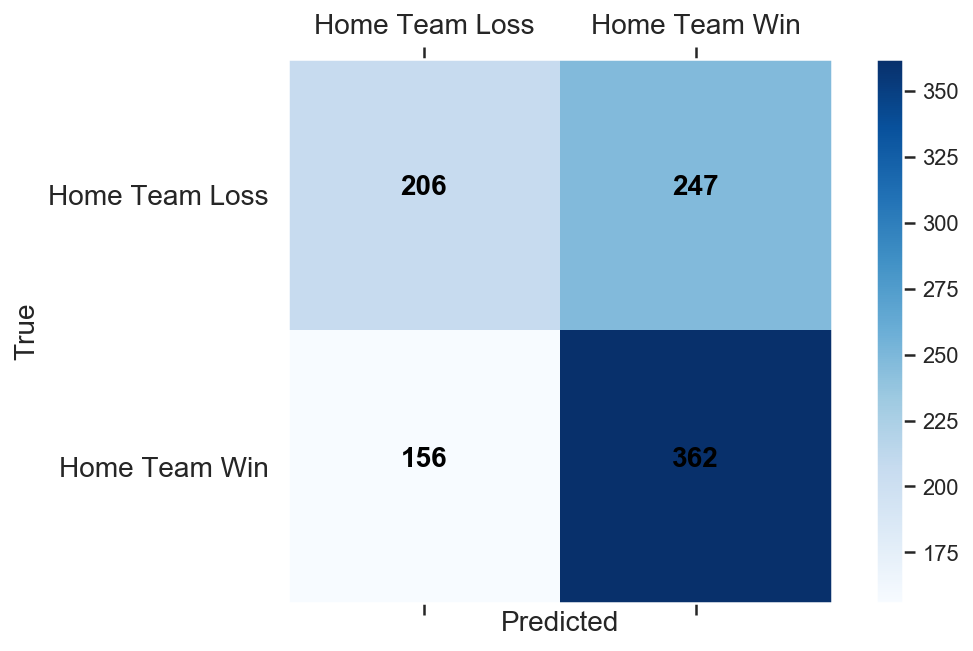

accuracy: 58.47% (+/- 1.89%)
precision: 59.15% (+/- 1.29%)
recall: 69.48% (+/- 1.26%)
f1 score: 63.89% (+/- 1.04%)
roc_auc score: 57.78% (+/- 2.10%)


In [208]:
voting_clf = VotingClassifier(
    estimators=[('lr',lr_auc),
                ('rf',rf_auc),
                ('gb',gb_f1)],
    voting='soft')

pipeline_cv(5,X,y,voting_clf)



//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,0,1,accuracy,macro avg,weighted avg
precision,0.628362,0.618117,0.622428,0.623240,0.623092
recall,0.544492,0.696000,0.622428,0.620246,0.622428
f1-score,0.583428,0.654751,0.622428,0.619089,0.620117
support,472.000000,500.000000,0.622428,972.000000,972.000000


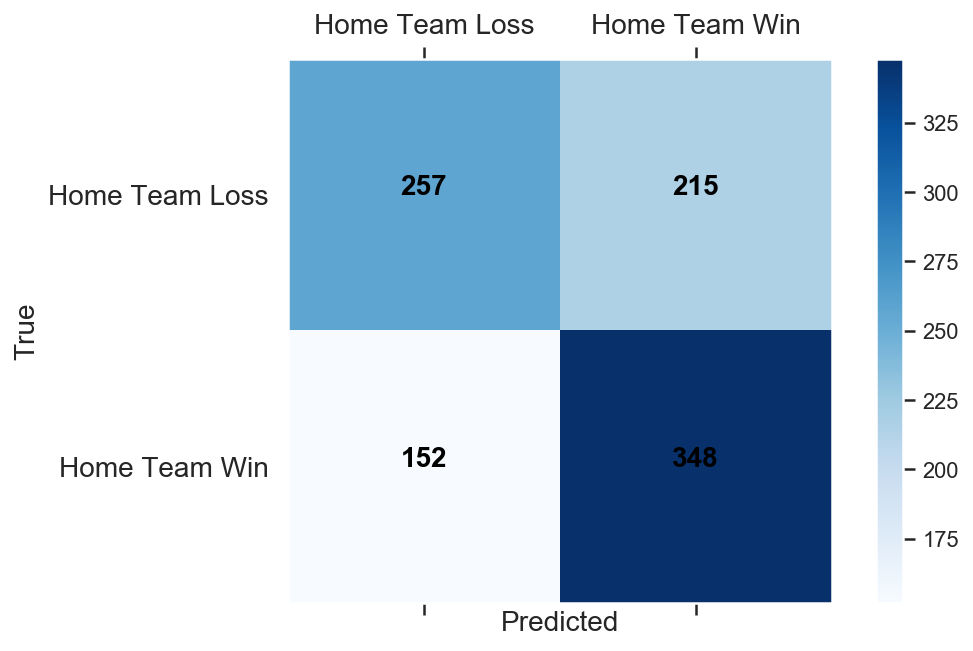

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('lr',lr_auc),
                ('rf',rf_f1),
                ('gb',gb_f1),
                ('voting',voting_clf)])

pipeline_cv(5,X,y,stacking_clf)

stacking_clf.fit(X_train,y_train)
stacking_preds=stacking_clf.predict(X_test)
plot_confusion_matrix(y_test,stacking_preds)

### Feature Importance

In [125]:
# lr_estimator_classifier = lr_search.best_estimator_.named_steps['classifier']

coef_dict = {}
for coef, feat in zip(lr_estimator_classifier.coef_[0,:],list(X)):
    coef_dict[feat] = coef

coef_dict

In [198]:
sgd_grid_search.best_params_

{'attr_adder__add_hitters_slashInteraction': True,
 'classifier__alpha': 0.001,
 'classifier__loss': 'log',
 'classifier__penalty': 'l1',
 'classifier__tol': 0.0001,
 'interaction__degree': 1,
 'nan_imputer__strategy': 'mean',
 'scaler__with_mean': True,
 'scaler__with_std': False,
 'zero_imputer__strategy': 'median'}

In [ ]:
sgd_clf = SGDClassifier()